In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-0rdumi2x
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-0rdumi2x
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33787 sha256=2f29e3bcbb659e017902c9c981309c92f6506574ddfb160c32bf9e75dc021d18
  Stored in directory: /tmp/pip-ephem-wheel-cache-_mwyapve/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation-models


In [ ]:
%env SM_FRAMEWORK=tf.keras
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras

from keras.utils import normalize
from keras.metrics import MeanIoU
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.datasets import cifar10
from keras.utils import normalize, to_categorical

#Resizing images, if needed
#SIZE_X = 128
#SIZE_Y = 128
n_classes=1 #Number of classes for segmentation

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip  '/content/drive/MyDrive/dataset_tubulitis/Tiff_PNG/Images.zip' -d '/content/drive/MyDrive/dataset_tubulitis/Tiff_PNG/Images/'

In [ ]:
!unzip  '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/tiles_png.zip' -d '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/'
!unzip  '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/labels_png.zip' -d '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/'

In [ ]:
!unzip  '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/train_images.zip' -d '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/'
!unzip  '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/train_masks.zip' -d '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/'
!unzip  '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/val_images.zip' -d '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/'
!unzip  '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/val_masks.zip' -d '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/'

In [ ]:
#!unzip  '/content/drive/MyDrive/dataset_tubulitis/Tiff_PNG/Labels.zip' -d '/content/drive/MyDrive/dataset_tubulitis/Tiff_PNG/Labels/'

In [ ]:
#Capture mask/label info as a list
train_masks = []
train_images = []

for directory_path in sorted(glob.glob('/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/')):
    for img_path in sorted(glob.glob(os.path.join(directory_path, 'tiles_png/',"*.png"))):
        img = cv2.imread(img_path, 1)
        #img = cv2.normalize(img,None, alpha=0., beta=1., norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Normalize H&E
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

    for mask_path in sorted(glob.glob(os.path.join(directory_path, 'labels_png/',"*.png"))):
        mask = cv2.imread(mask_path, 0)
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing
train_images = np.array(train_images)
train_masks = np.array(train_masks)

In [ ]:
import os
import tensorflow as tf

class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, tiles_dir, masks_dir, batch_size=32):
        self.tiles_dir = tiles_dir
        self.masks_dir = masks_dir
        self.batch_size = batch_size

        self.tile_filenames = os.listdir(tiles_dir)

    def __len__(self):
        return len(self.tile_filenames) // self.batch_size

    def __getitem__(self, idx):
        batch_tile_filenames = self.tile_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_tiles = []
        batch_masks = []

        for tile_filename in batch_tile_filenames:
            tile_path = os.path.join(self.tiles_dir, tile_filename)
            mask_filename = tile_filename.replace('*.png', '_mask.png')  # Assuming masks have the same filename with "_mask" suffix
            mask_path = os.path.join(self.masks_dir, mask_filename)

            # Load and preprocess tile
            tile = tf.io.read_file(tile_path)
            tile = tf.image.decode_png(tile, channels=3)
            tile = tf.image.resize(tile, [512, 512])
            tile = tf.cast(tile, tf.float32) / 255.0

            # Load and preprocess mask
            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.resize(mask, [512, 512])
            mask = tf.cast(mask, tf.float32) / 255.0

            batch_tiles.append(tile)
            batch_masks.append(mask)

        return tf.stack(batch_tiles), tf.stack(batch_masks)

# Example usage
tiles_train_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/train_images'
masks_train_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/train_masks'
tiles_val_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/val_images'
masks_val_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/val_masks'
batch_size = 4


train_dataset = CustomDataset(tiles_train_dir, masks_train_dir, batch_size=batch_size)
val_dataset = CustomDataset(tiles_val_dir, masks_val_dir, batch_size=batch_size)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf

class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, tiles_dir, masks_dir, batch_size=32):
        self.tiles_dir = tiles_dir
        self.masks_dir = masks_dir
        self.batch_size = batch_size

        self.tile_filenames = os.listdir(tiles_dir)

    def __len__(self):
        return len(self.tile_filenames) // self.batch_size

    def __getitem__(self, idx):
        batch_tile_filenames = self.tile_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_tiles = []
        batch_masks = []

        for tile_filename in batch_tile_filenames:
            tile_path = os.path.join(self.tiles_dir, tile_filename)
            mask_filename = tile_filename.replace('*.png', '_mask.png')  # Assuming masks have the same filename with "_mask" suffix
            mask_path = os.path.join(self.masks_dir, mask_filename)

            # Load and preprocess tile
            tile = tf.io.read_file(tile_path)
            tile = tf.image.decode_png(tile, channels=3)
            tile = tf.image.resize(tile, [512, 512])
            tile = tf.cast(tile, tf.float32) / 255.0

            # Load and preprocess mask
            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.resize(mask, [512, 512])
            mask = tf.cast(mask, tf.float32) / 255.0

            batch_tiles.append(tile)
            batch_masks.append(mask)

        return tf.stack(batch_tiles), tf.stack(batch_masks)

# Пути к данным
tiles_train_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/train_images'
masks_train_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/train_masks'
tiles_val_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/val_images'
masks_val_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/train_val/val_masks'

# Создание генератора для обучающего датасета
train_gen = CustomDataset(tiles_train_dir, masks_train_dir, batch_size=batch_size)

# Создание генератора для валидационного датасета
val_gen = CustomDataset(tiles_val_dir, masks_val_dir, batch_size=batch_size)

In [ ]:
import os

# Пути к изображениям и маскам
image_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/tiles_png'
mask_dir = '/content/drive/MyDrive/dataset_tubulitis/only_tubulitis/labels_png'

# Список файлов в директориях изображений и масок
image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

# Проверка количества файлов
if len(image_filenames) != len(mask_filenames):
    raise ValueError("Количество изображений и масок не совпадает.")

# Проверка соответствия изображений и масок
for image_filename, mask_filename in zip(image_filenames, mask_filenames):
    image_path = os.path.join(image_dir, image_filename)
    mask_path = os.path.join(mask_dir, mask_filename)
    if not os.path.exists(image_path) or not os.path.exists(mask_path):
        raise ValueError(f"Изображение {image_filename} или маска {mask_filename} отсутствует.")

# Все проверки пройдены, можно продолжить работу с данными

In [ ]:
print(train_images.shape)
print(train_masks.shape)

(3036, 512, 512, 3)
(3036, 512, 512)


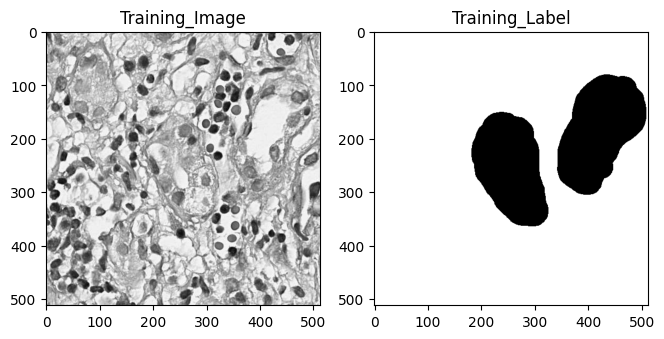

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Training_Image')
plt.imshow(train_images[100,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Training_Label')
plt.imshow(train_masks[100,:,:], cmap='gray')

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
np.unique(train_masks_encoded_original_shape)

In [ ]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.20, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
#X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

In [ ]:
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

Class values in the dataset are ...  [ 76 255]


In [ ]:
from keras.utils import to_categorical
#train_masks_tubul = to_categorical(y_train, num_classes=n_classes)
#y_train_tubul = train_masks_tubul.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



#test_masks_tubul = to_categorical(y_test, num_classes=n_classes)
#y_test_tubul = test_masks_tubul.reshape((y_test.shape[0], y_test.shape[1], #y_test.shape[2], n_classes))


In [ ]:
print(X_train.shape)
print(y_train.shape)

(2428, 512, 512, 3)
(2428, 512, 512)


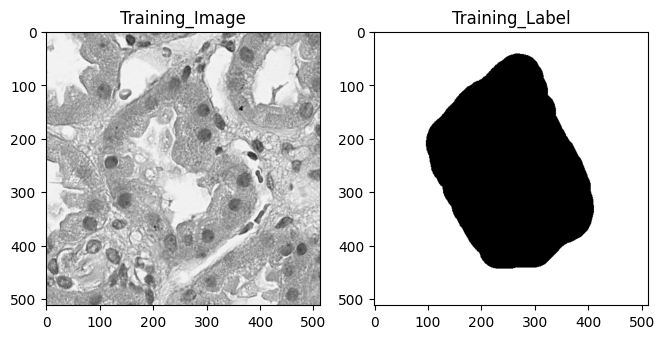

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Training_Image')
plt.imshow(X_train[20,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Training_Label')
plt.imshow(y_train[20,:,:], cmap='gray')

In [ ]:
from keras import backend
import keras.backend as K

In [ ]:
#Reused parameters in all models

n_classes=1
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
#dice_loss = sm.losses.DiceLoss(class_weights=K.constant([0.25, 0.25, 0.25, 0.25]))
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # OR sm.losses.categorical_focal_dice_loss

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
    sm.metrics.Recall(threshold=0.5),
    sm.metrics.Precision(threshold=0.5)]

In [ ]:
#ResNet34
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
#X_train = preprocess_input1(X_train)
#X_test = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())


history=model1.fit_generator(train_gen,
          epochs=10,
          verbose=1,
          validation_data=val_gen)


model1.save('res34_backbone_50epochs.hdf5')

NameError: name 'sm' is not defined

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
###Model 2

BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
#model2.compile(optim, total_loss, metrics)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())


history2=model2.fit(X_train2,
          y_train_tubul,
          batch_size=8,
          epochs=50,
          verbose=1,
          validation_data=(X_test2, y_test_tubul))


model2.save('inceptionv3_backbone_50epochs.hdf5')

In [ ]:
###Model 3

BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
#X_train3 = preprocess_input3(X_train)
#X_test3 = preprocess_input3(X_test)


# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics)
#model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model3.summary())

history3=model3.fit_generator(train_gen,
          epochs=10,
          verbose=1,
          validation_data=val_gen)


model3.save('vgg19_backbone_50epochs.hdf5')

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                             

<ipython-input-7-88f0f4e914bf>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3=model3.fit_generator(train_gen,


Epoch 1/10
116/607 [====>.........................] - ETA: 33:17 - loss: 1.6589 - iou_score: 0.8673 - f1-score: 0.9278 - recall: 1.0000 - precision: 0.8673

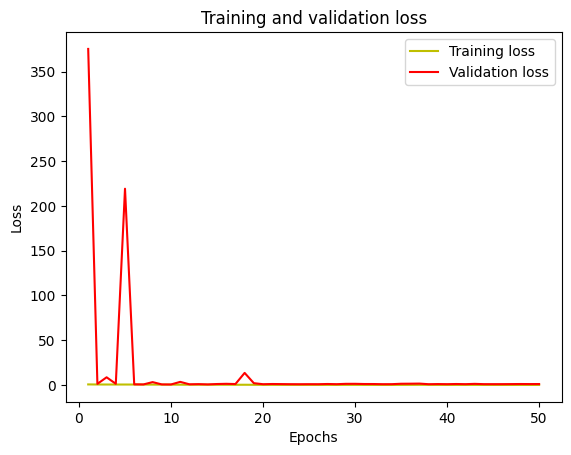

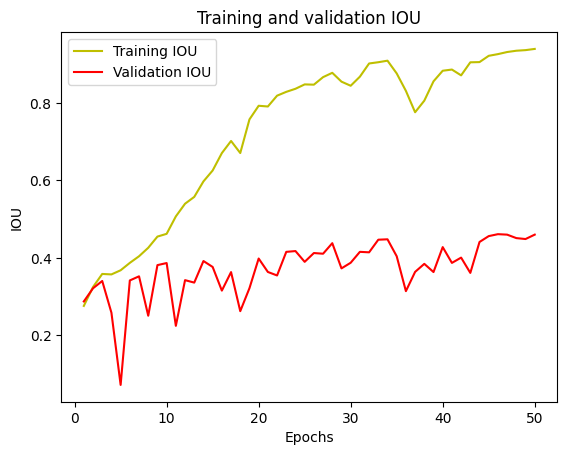

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

In [ ]:
#model1 = load_model('/content/res34_backbone_50epochs.hdf5', compile=False)
model2 = load_model('/content/inceptionv3_backbone_50epochs.hdf5', compile=False)

In [ ]:
#IOU
y_pred2=model2.predict(X_test2)
y_pred2_argmax=np.argmax(y_pred2, axis=3)

4/4 [==============================] - 5s 129ms/step


In [ ]:
#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred2_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.46093273


1/1 [==============================] - 0s 46ms/step


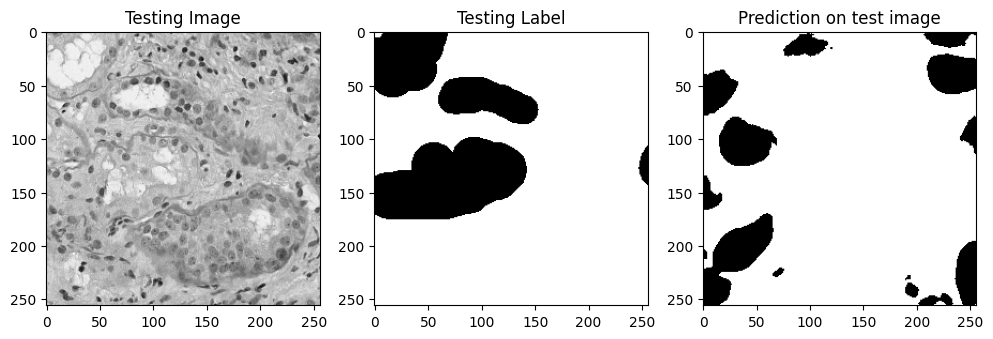

In [ ]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test2[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input2 = preprocess_input2(test_img_input)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()